In [1]:
import sys
sys.path.append("../")
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import scipy.constants as cst
from axessettings import AxesSetting, linear_sim

In [2]:
data = pd.read_excel("data.xlsx", sheet_name="(1)", skiprows=[1])

def cmap(x):
    dict_convert = {
        "10m": "red",
        "1000u": "orange",
        "100u": "green",
        "30u": "blue"
    }
    return dict_convert[x]
def R_V(x):
    dict_convert = {
        "10m": 4.50,
        "1000u": 0.88e3,
        "100u": 6.75e3,
        "30u": 4.69e3
    }
    return dict_convert[x]
def Ierror(x):
    # Unit: A
    dict_convert = {
        "10m": 0.2e-3,
        "1000u": 20e-6,
        "100u": 2e-6,
        "30u": 0.5e-6
    }
    return dict_convert[x] * 0.2

# data["color"] = data["type_I"].apply(cmap)
data["R_V"] = data["type_I"].apply(R_V)
data["I_m"] /= 1000
data["I_error"] = data["type_I"].apply(Ierror)
data["V"] = data["V_m"]-data["R_V"]*data["I_m"]
data = data[data["I_m"] > 3e-7]

In [3]:
def I_pn(V, Is):
    return Is * (np.exp(cst.e * V / (cst.k * (273.15+25))) - 1)

def V_pn(I, Is, R, n):
    return n * cst.k * (273.15+25) / cst.e * np.log(I/Is + 1) + R * I

[2.45669944e-14 2.31512734e+01 1.08913573e+00]
[5.29278642e-19]


/tmp/ipykernel_377825/1968509001.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(np.geomspace(1e-5, 10, 7))


[Text(0, 1e-08, '1e-05'),
 Text(0, 1e-07, '0.0001'),
 Text(0, 1e-06, '0.001'),
 Text(0, 1e-05, '0.01'),
 Text(0, 0.0001, '0.1'),
 Text(0, 0.001, '1.0'),
 Text(0, 0.01, '10.0'),
 Text(0, 0.1, ''),
 Text(0, 1.0, '')]

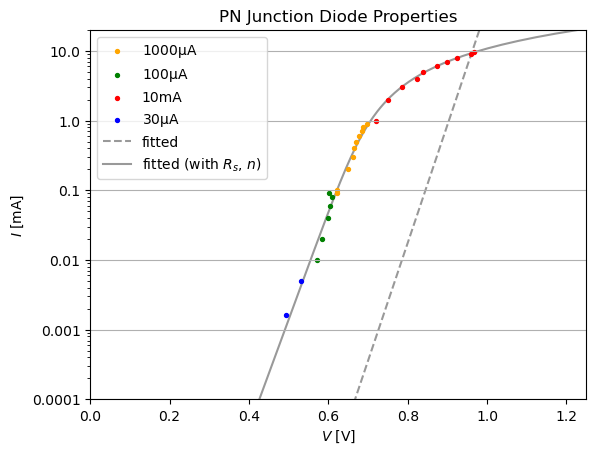

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)

popt1, pcov1 = curve_fit(V_pn, data["I_m"], data["V"], p0=(3e-15, 25, 1))
popt2, pcov2 = curve_fit(I_pn, data["V"], data["I_m"], p0=(3e-15))
print(popt1)
print(popt2)

axessetting = AxesSetting(legend=True, xlabel="$V$ [V]", grid="y", ylabel="$I$ [mA]", title="PN Junction Diode Properties", xlim=(0, 1.25), ylim=(1e-7, 2e-2), yscale="log")

dict_labelname = {
    "10m": "10mA",
    "1000u": "1000$\\rm{\mu}$A",
    "100u": "100$\\rm{\mu}$A",
    "30u": "30$\\rm{\mu}$A"
}
for i_type, group in data.groupby("type_I"):
    ax.scatter(group["V"], group["I_m"], color=cmap(i_type), s=8, label=dict_labelname[i_type])

# axessetting.plot_func_param(ax, lambda I: V_pn(I, 3e-15, 25), lambda I: I, (1e-7, 1e-1), zorder=-1, c="black", alpha=0.4)
axessetting.plot_func(ax, lambda V: I_pn(V, *popt2), zorder=-1, c="black", alpha=0.4, label="fitted", linestyle="--")
axessetting.plot_func_param(ax, lambda I: V_pn(I, *popt1), lambda I: I, np.geomspace(1e-7, 20e-3, 200), zorder=-1, c="black", alpha=0.4, label="fitted (with $R_s$, $n$)")

axessetting.apply_axes(ax)
#ax.set_yticklabels(ax.get_yticks()*1000)
ax.set_yticklabels(np.geomspace(1e-5, 10, 7))